In [3]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True).to(device)

def get_embedding_fp16(dna_seq):
    """
    Compute the mean-pooled embedding using mixed precision (FP16)
    """
    inputs = tokenizer(dna_seq, return_tensors='pt')["input_ids"].to(device)
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            hidden_states = model(inputs)[0] 
        embedding = torch.mean(hidden_states[0], dim=0)
    return embedding.cpu().numpy()



c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\haris\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-S\2efd650282ec5d5ab377c787c76ea56b723f6b7c\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [4]:
def get_embedding_chunked(dna_seq, chunk_size=512, overlap=0):
    """
    Compute the embedding for a long DNA sequence by splitting it into smaller chunks.
    
    Parameters:
      dna_seq (str): The input DNA sequence.
      chunk_size (int): Maximum chunk size (should be within model limits).
      overlap (int): Number of tokens to overlap between chunks (for smooth transitions).
    
    Returns:
      numpy.ndarray: The mean-pooled embedding over the sequence.
    """
    import torch.cuda.amp as amp
    emb_list = []
    step = chunk_size - overlap if overlap < chunk_size else 1

    for i in range(0, len(dna_seq), step):
        chunk = dna_seq[i : i + chunk_size]
        inputs = tokenizer(chunk, return_tensors='pt')["input_ids"].to(device)
        with torch.no_grad():
            with amp.autocast():
                hidden_states = model(inputs)[0]
            chunk_embedding = torch.mean(hidden_states[0], dim=0)
        emb_list.append(chunk_embedding)
    
    full_embedding = torch.mean(torch.stack(emb_list), dim=0)
    return full_embedding.cpu().numpy()



In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("./coronaviridae_sequences_with_genomes_final.csv")

# Use first 150 sequences only
embeddings = []

for i in range(150):
    seq = df["Genomic Sequence"].iloc[i]
    emb = get_embedding_chunked(seq)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)

labels = df["Organism"].iloc[:150]
labels_encoded = pd.Categorical(labels).codes

C:\Users\haris\AppData\Local\Temp\ipykernel_27604\3919283913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


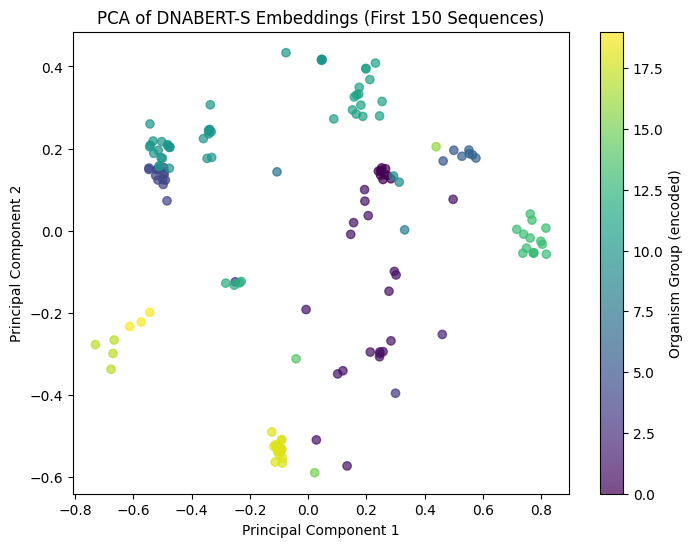

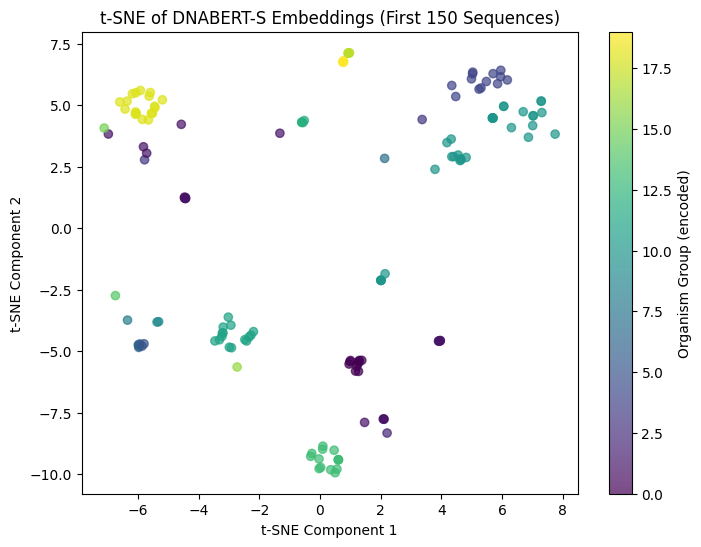

In [18]:

# PCA Visualization
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("PCA of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("t-SNE of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Determine the number of unique clusters in the first 150 labels
n_unique_clusters = len(np.unique(labels_encoded))
print(f"Number of unique organism groups in subset: {n_unique_clusters}")

kmeans = KMeans(n_clusters=n_unique_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Compute Silhouette Score
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score (subset): {sil_score:.3f}")

# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels_encoded, clusters)
print(f"Adjusted Rand Index (ARI, subset): {ari:.3f}")

Number of unique organism groups in subset: 20
Silhouette Score (subset): 0.468
Adjusted Rand Index (ARI, subset): 0.664


In [8]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("./BertDnaS_Run2.csv")

# Compute embeddings for each sequence
embeddings = []

# for i in range(150):
#     seq = df["Genomic Sequence"][i]
#     emb = get_embedding_chunked(seq)
#     embeddings.append(emb)

for seq in df["Genomic Sequence"]:
    emb = get_embedding_chunked(seq)
    embeddings.append(emb)

import numpy as np
embeddings = np.vstack(embeddings)


labels = df["GBSeq_organism"]
# labels = df["Organism"]

C:\Users\haris\AppData\Local\Temp\ipykernel_27604\3919283913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


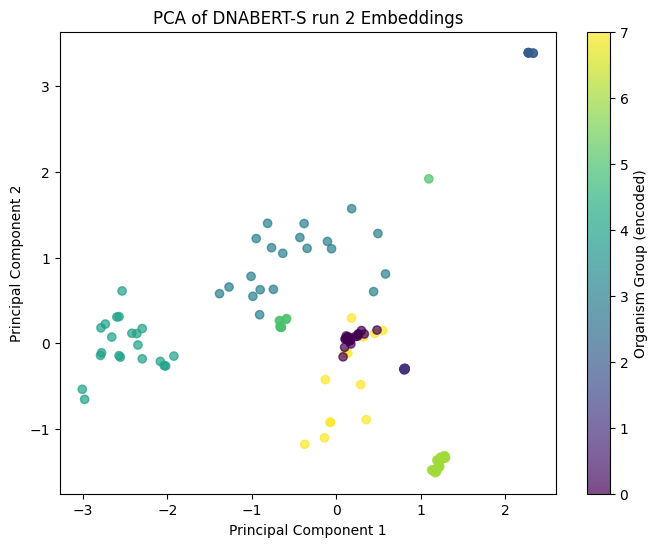

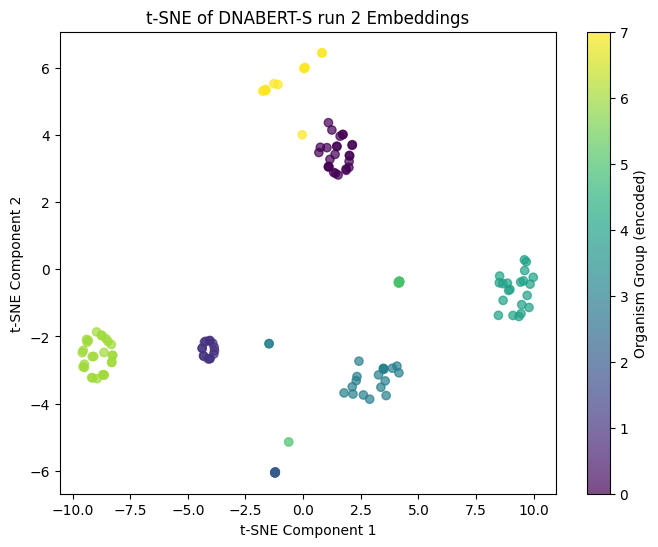

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert categorical labels to numeric codes for coloring
labels_encoded = pd.Categorical(labels).codes

# --- PCA Visualization ---
pca = PCA(n_components=2 )
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("PCA of DNABERT-S run 2 Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

# --- t-SNE Visualization ---
# t-SNE may capture nonlinear relationships better.
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("t-SNE of DNABERT-S run 2 Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Set number of clusters equal to the number of unique organisms
n_clusters = len(pd.unique(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Silhouette score: higher is better (range from -1 to 1)
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {sil_score:.3f}")


true_labels = labels_encoded
ari = adjusted_rand_score(true_labels, clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Score: 0.545
Adjusted Rand Index (ARI): 0.817


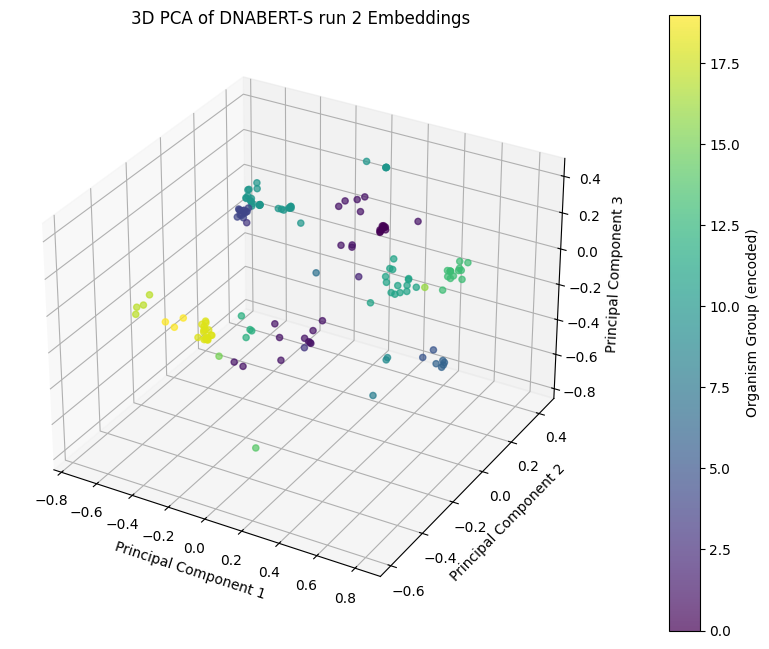

In [20]:
pca3d = PCA(n_components=3)
embeddings_pca3d = pca3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_pca3d[:, 0], embeddings_pca3d[:, 1], embeddings_pca3d[:, 2],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
ax.set_title("3D PCA of DNABERT-S run 2 Embeddings")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

cbar = fig.colorbar(scatter, ax=ax, pad = 0.1)
cbar.set_label("Organism Group (encoded)")
plt.show()

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("./Random_BertDNA_RUN_1.csv")

# Use first 150 sequences only
embeddings = []

for i in range(1000):
    seq = df["Genomic Sequence"].iloc[i]
    emb = get_embedding_chunked(seq)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)

labels = df["GBSeq_organism"].iloc[:1000]
labels_encoded = pd.Categorical(labels).codes

C:\Users\haris\AppData\Local\Temp\ipykernel_58212\3919283913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\haris\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-S\2efd650282ec5d5ab377c787c76ea56b723f6b7c\bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 514
  warnings.warn(


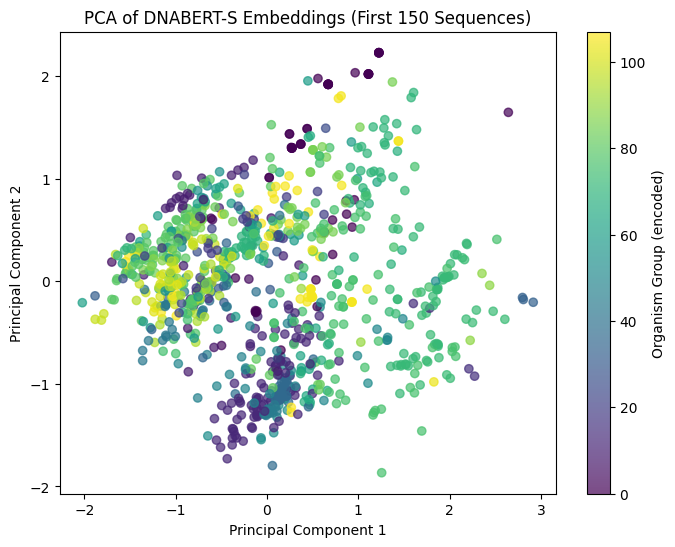

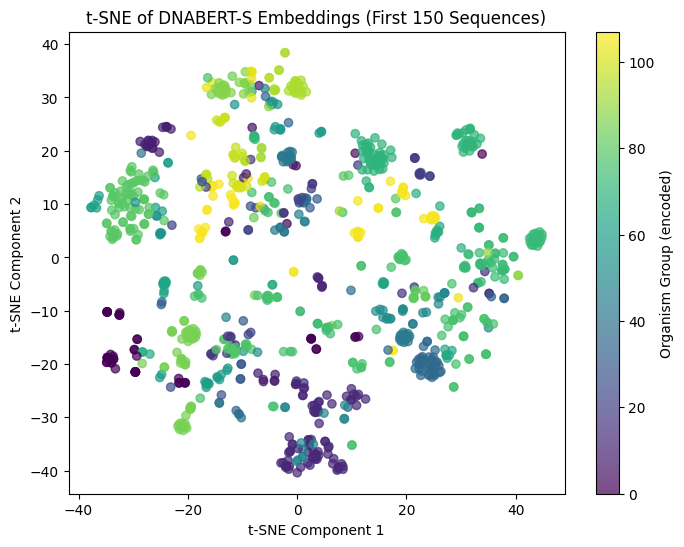

In [4]:
# PCA Visualization

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("PCA of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("t-SNE of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Set number of clusters equal to the number of unique organisms
n_clusters = len(pd.unique(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Silhouette score: higher is better (range from -1 to 1)
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {sil_score:.3f}")


true_labels = labels_encoded
ari = adjusted_rand_score(true_labels, clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Score: 0.283
Adjusted Rand Index (ARI): 0.383


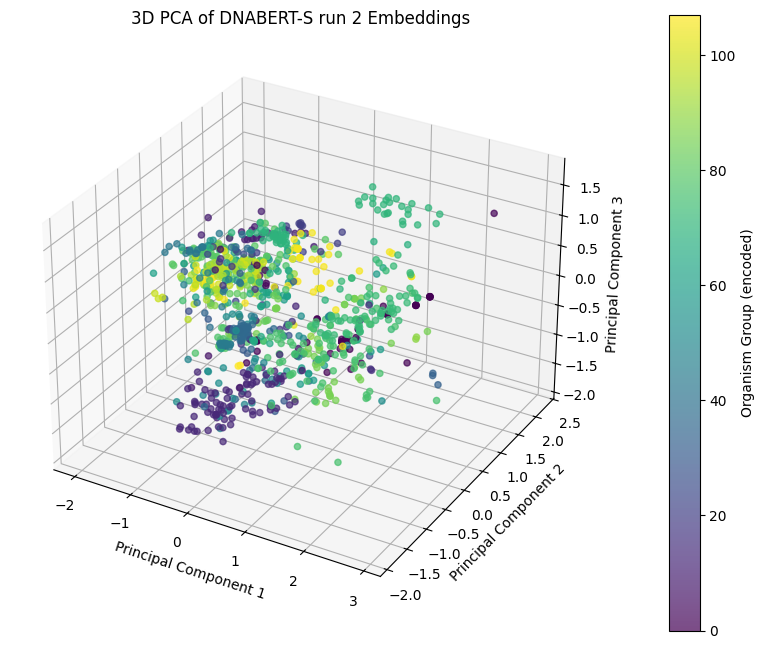

In [6]:
pca3d = PCA(n_components=3)
embeddings_pca3d = pca3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_pca3d[:, 0], embeddings_pca3d[:, 1], embeddings_pca3d[:, 2],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
ax.set_title("3D PCA of DNABERT-S run 2 Embeddings")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

cbar = fig.colorbar(scatter, ax=ax, pad = 0.1)
cbar.set_label("Organism Group (encoded)")
plt.show()

In [9]:
pip install umap-learn


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 43.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ------------------------ --------------- 18.9/30.3 MB 88.5 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 76.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


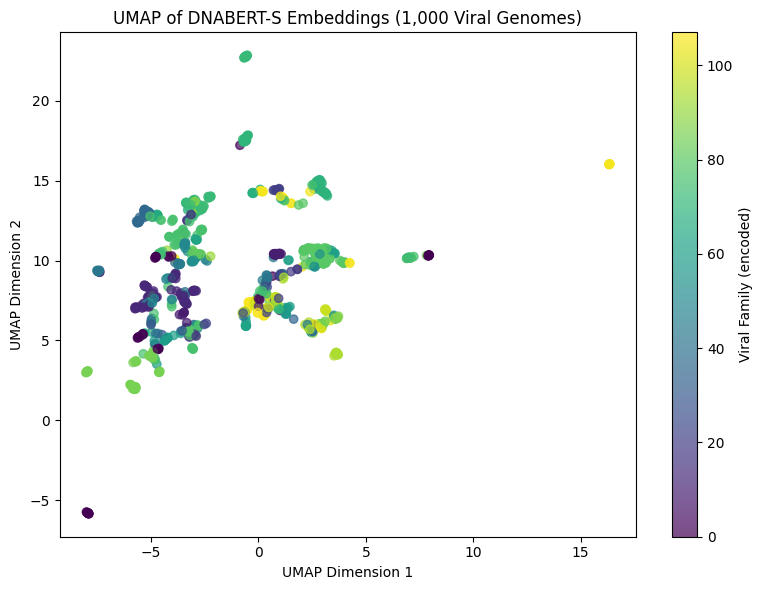

In [7]:
import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

# --- Assume you’ve already loaded your embeddings and labels ---
# embeddings: np.ndarray of shape (1000, 768)
# labels_encoded: np.ndarray of shape (1000,) with integer codes per family

# 1) UMAP projection to 2 dimensions
umap_reducer = UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings)

# 2) Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=labels_encoded,
    alpha=0.7
)
plt.title("UMAP of DNABERT-S Embeddings (1,000 Viral Genomes)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label="Viral Family (encoded)")
plt.tight_layout()
plt.show()


In [11]:
pip install plotly

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ------------------------- -------------- 9.4/14.8 MB 58.7 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 59.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# 1) Compute PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 2) Build a DataFrame for Plotly
df_pca = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    # If you have string labels:
    "Organism": df["GBSeq_organism"].iloc[:len(pca_result)].values,
    # Or use numeric codes:
    # "Organism": labels_encoded
})

# 3) Plot with Plotly Express
fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="Organism",
    title="PCA of DNABERT-S Embeddings (Interactive)",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"}
)

# Optional styling
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(legend_title_text="Viral Organism", width=800, height=600)

fig.show()


In [12]:
import plotly.express as px

fig.write_html("plot.html")

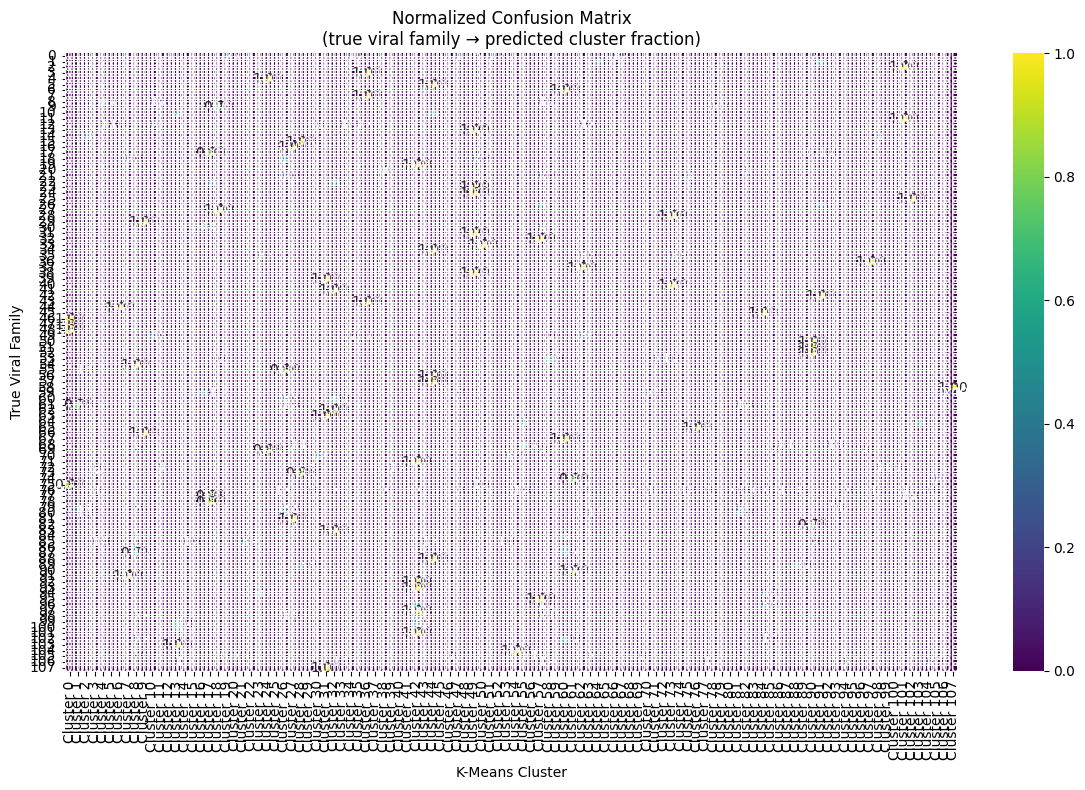

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Run K-Means
n_clusters = len(np.unique(labels_encoded))
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
cluster_preds = kmeans.labels_

# 2. Build confusion matrix (counts)
cm = confusion_matrix(labels_encoded, cluster_preds)

# 3. Normalize per-row (true-label) so each row sums to 1
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# 4. Get the actual family names in the order of labels_encoded
family_cats = pd.Categorical(true_labels).categories

# 5. Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
    yticklabels=family_cats
)
plt.title("Normalized Confusion Matrix\n(true viral family → predicted cluster fraction)")
plt.xlabel("K-Means Cluster")
plt.ylabel("True Viral Family")
plt.tight_layout()
plt.show()


Overall silhouette score: 0.283


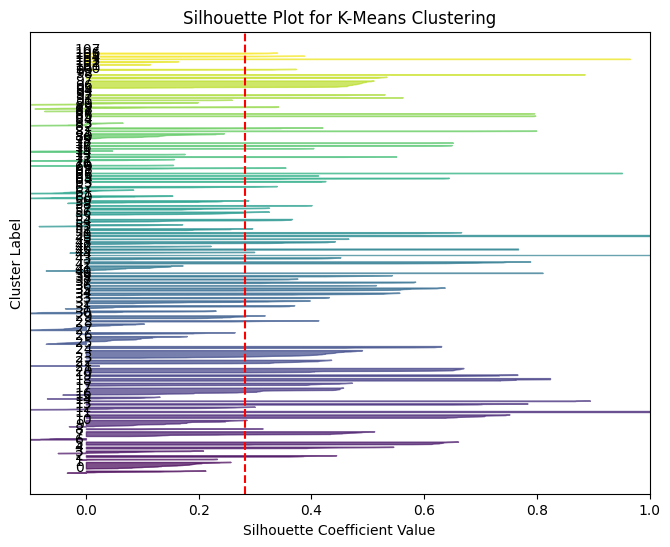

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


# 1) Fit K-Means (or reuse your existing cluster assignments)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# 2) Compute the overall silhouette score (optional)
print("Overall silhouette score:", 
      silhouette_score(embeddings, cluster_labels).round(3))

sil_values = silhouette_samples(embeddings, cluster_labels)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10  # spacing offset

for cluster in range(n_clusters):
    cluster_sil = sil_values[cluster_labels == cluster]
    cluster_sil.sort()
    
    size_cluster = cluster_sil.shape[0]
    y_upper = y_lower + size_cluster
    
    color = plt.cm.viridis(cluster / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax.text(-0.02, y_lower + 0.5 * size_cluster, str(cluster))
    
    y_lower = y_upper + 10  # 10-sample gap between clusters

ax.set_title("Silhouette Plot for K-Means Clustering")
ax.set_xlabel("Silhouette Coefficient Value")
ax.set_ylabel("Cluster Label")
ax.axvline(x=np.mean(sil_values), color="red", linestyle="--")
ax.set_yticks([])  # hide y-ticks
ax.set_xlim([-0.1, 1])
plt.show()


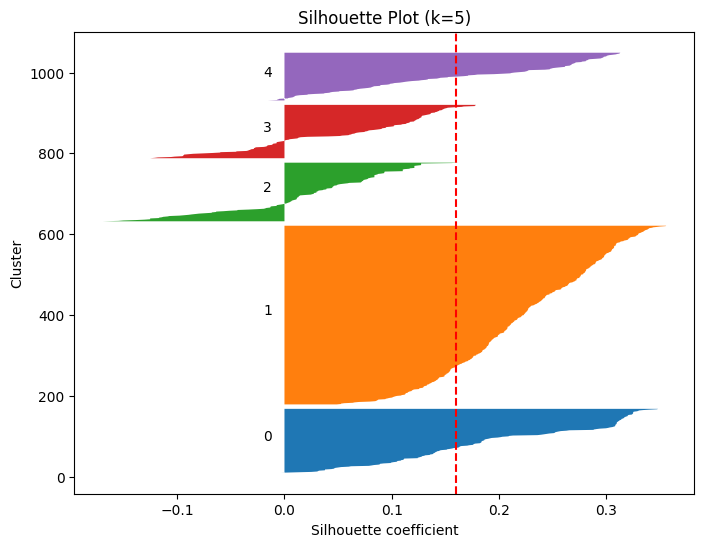

In [11]:
# 1) find best k
ks = range(2, 21)
sil_scores = [silhouette_score(embeddings, 
               KMeans(n_clusters=k, random_state=42)
               .fit_predict(embeddings))
             for k in ks]
best_k = ks[np.argmax(sil_scores)]

# 2) run final KMeans
final_km = KMeans(n_clusters=best_k, random_state=42).fit(embeddings)
final_labels = final_km.labels_

# 3) silhouette plot for final_km
from sklearn.metrics import silhouette_samples
sil_vals = silhouette_samples(embeddings, final_labels)

import matplotlib.pyplot as plt
y_lower = 10
plt.figure(figsize=(8,6))
for i in range(best_k):
    cluster_sil = np.sort(sil_vals[final_labels == i])
    y_upper = y_lower + len(cluster_sil)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil)
    plt.text(-0.02, y_lower + len(cluster_sil)/2, str(i))
    y_lower = y_upper + 10

plt.axvline(np.mean(sil_vals), color="red", linestyle="--")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title(f"Silhouette Plot (k={best_k})")
plt.show()


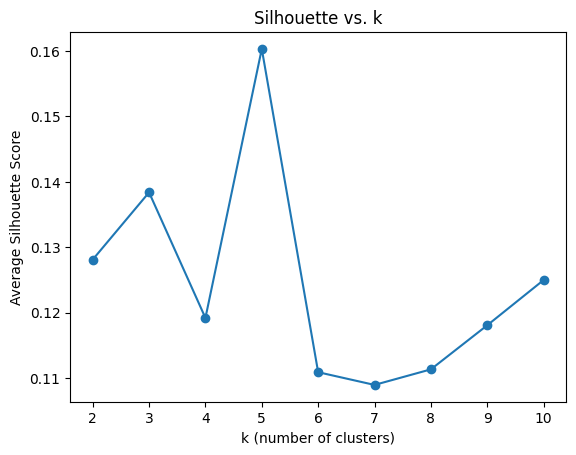

Best k by silhouette: 5


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = []
ks = range(2, 11)
for k in ks:
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(embeddings)
    sil_scores.append(silhouette_score(embeddings, labels))

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette vs. k")
plt.show()

best_k = ks[sil_scores.index(max(sil_scores))]
print("Best k by silhouette:", best_k)


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("./Random_BertDNA_RUN_1.csv")

print(df['GBSeq_organism'].nunique())  # Check unique organism groups
print(df.nunique())  # Check unique sequences

173
accession           6669
seq_definition      6610
seq_length          2082
GBSeq_organism       173
Genomic Sequence    5815
dtype: int64


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./coronaviridae_sequences_with_genomes_final.csv")
print(df.nunique())  # Check unique sequences

Accession           5611
Description         5325
Organism             439
Length              1872
Source               465
Collection Date     2101
Isolate             3301
Strata                 2
Genomic Sequence    5428
dtype: int64


In [12]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# 1) Compute PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 2) Build a DataFrame for Plotly
df_pca = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    # If you have string labels:
    "Organism": df["GBSeq_organism"].iloc[:len(pca_result)].values,
    # Or use numeric codes:
    # "Organism": labels_encoded
})

# 3) Plot with Plotly Express
fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="Organism",
    title="PCA of DNABERT-S Embeddings (Interactive)",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"}
)

# Optional styling
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(legend_title_text="Viral Organism", width=800, height=600)

fig.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. Load the CSV
df = pd.read_csv("./coronaviridae_sequences_with_genomes_final.csv")

mask = df["Genomic Sequence"].notna() & (df["Genomic Sequence"].str.strip() != "")
df_valid = df.loc[mask]

embeddings = []
for seq in df_valid["Genomic Sequence"]:
    emb_vec = get_embedding_chunked(seq)     # your helper
    embeddings.append(emb_vec)

embeddings = np.vstack(embeddings)           # shape: (n_valid_samples, embedding_dim)



C:\Users\haris\AppData\Local\Temp\ipykernel_26752\3919283913.py:21: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# 1) Compute PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 2) Build a DataFrame for Plotly
df_pca = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    # If you have string labels:
    "Organism": df["Organism"].iloc[:len(pca_result)].values,
 
})

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="Organism",
    title="PCA of Coronaviridae Embeddings (439 Unique Organisms) (Interactive)",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"}
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(legend_title_text="Viral Organism", width=800, height=600)

fig.show()

In [16]:
print(embeddings.shape)  # Check shape of embeddings
labels = df_valid["Organism"]
labels_encoded = pd.Categorical(labels).codes

(5606, 768)


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Set number of clusters equal to the number of unique organisms
n_clusters = len(pd.unique(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Silhouette score: higher is better (range from -1 to 1)
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {sil_score:.3f}")


true_labels = labels_encoded
ari = adjusted_rand_score(true_labels, clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Score: 0.223
Adjusted Rand Index (ARI): 0.138


In [18]:
import plotly.express as px

fig.write_html("coronaviridae_439_Organisms_plot.html")